# 프로젝트: 뉴스기사 요약해보기

## 결과

### 실제 결과와 요약문 비교하기 (추상적 요약)
    - 잘안된것같다

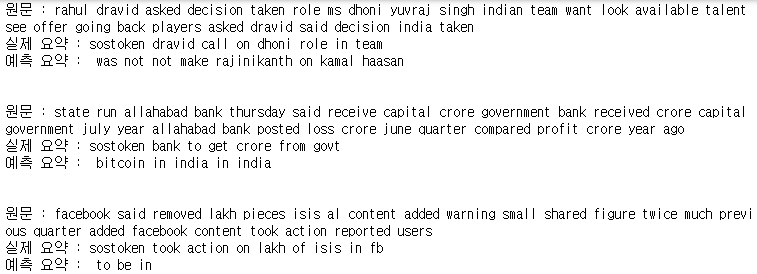

    

- max_len을 60으로 진행해서 모든 데이터를 사용하니 결과가 좀더 좋아졌다
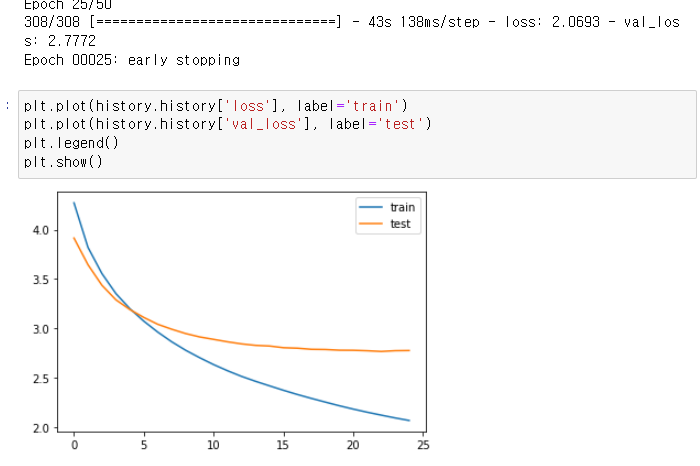

### 추출적 요약
    - 위 결과와 비교해 보려고 같은 문장을 작성해서 넣었는데 아예 요약이 안된다. 너무 짧나?

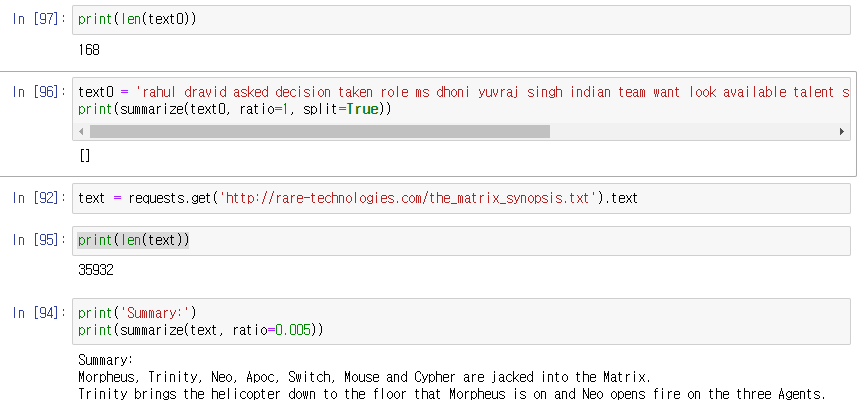


### 문제 해결
    - 전처리가 되어있는 문장을 영어로 인식을 못하는걸까 전처리가 아예안된 문장을 넣으니 작동이되었다
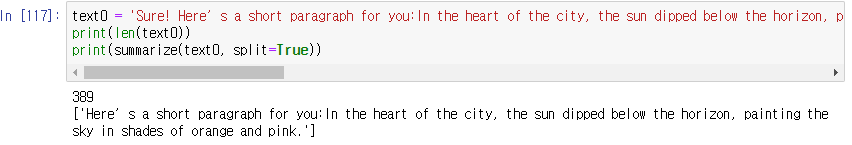

# 회고

- 오늘 오전 시간을 안했더니 진도 따라가는데 벅찼다
- 전처리 코드하나하나가 이해가 안되는 부분이있어서 조금 따라가 보고있는중
- decoder 코드 부분은 좀더 알아봐야겠다

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd


import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.tail(10)

,headlines,text
98391,Retired US Navy Admiral arrested in sex for se...,Retired US Navy Admiral Bruce Loveless and eig...
98392,Indian has world record for most lit candles i...,Dinesh Shivnath Upadhyaya from Mumbai is recog...
98393,"Startup makes Ã¢ÂÂ¹23,000 smart bag to freshe...",A Los Angeles-based startup has developed 'Paq...
98394,Kashmiri separatist leaders summoned over mone...,The Enforcement Directorate has summoned Jammu...
98395,Pakistan starts building fence along Afghanist...,"Pakistan has started building a nearly 2,400-k..."
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


# Step 2. 데이터 전처리하기 (추상적 요약)

In [4]:
## 정규화 사전

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [5]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    
    # 
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    
    # from nltk.corpus import stopwords <- stopword는 라이브러리로 가져온거
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
data['text']

0        saurav kant alumnus upgrad iiit pg program mac...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india wickets fourth odi ...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 98360, dtype: object

In [17]:
clean_text = []

data['text'] = data['text'].apply(lambda x: preprocess_sentence(x))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

KeyboardInterrupt: 

In [ ]:
clean_headlines = []

data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

In [19]:
# data['text'] = clean_text
# data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [20]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 데이터 분포 분석
- 데이터 필터 진행

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


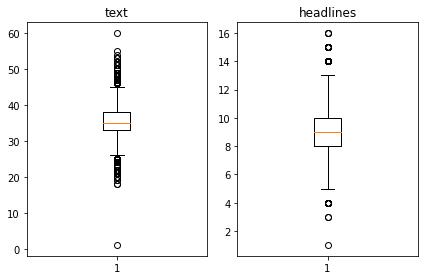

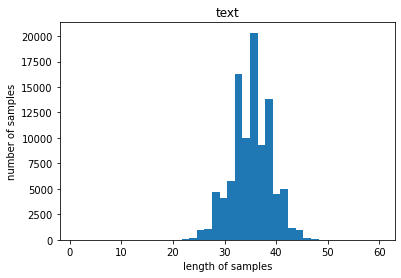

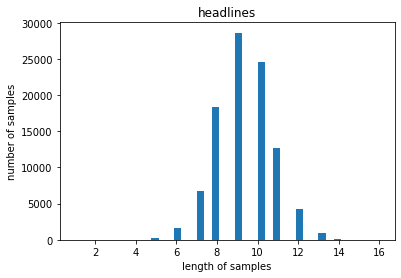

In [21]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 60
headlines_max_len = 16

In [23]:
filtered_data = data[(data['text'].apply(lambda x: len(x.split()) <= text_max_len)) &
(data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len))]

In [24]:
data = filtered_data.copy()

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블|
print('=3')

=3


In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
len(data)

98360

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


## 토크나이저

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69599
등장 빈도가 6번 이하인 희귀 단어의 수: 47476
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22123
단어 집합에서 희귀 단어의 비율: 68.21362375896204
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5016364801244717


In [33]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[38, 465, 10984, 595, 59, 740, 9130, 80, 1616, 696, 12, 378, 12984, 3724, 3257, 1488, 1616, 1, 23, 501, 16024, 14841, 180, 24, 6, 753, 4017, 1579, 229, 213, 229, 1616, 4713], [1268, 233, 22, 3174, 10985, 10475, 9131, 491, 3513, 311, 1040, 1244, 2990, 10985, 10475, 14, 1534, 3175, 5647, 11, 1985, 1268, 668, 1242, 30, 311, 14310, 17483, 8681, 968, 135, 1566, 311, 266], [28, 11, 308, 505, 866, 598, 11, 3890, 2645, 17484, 3015, 1360, 205, 1333, 866, 3015, 1868, 505, 3890, 92, 397, 230, 345, 505, 160, 70, 119, 5, 1991, 4506, 8018, 5, 26, 3890, 823, 438, 116]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30048
등장 빈도가 5번 이하인 희귀 단어의 수: 19650
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10398
단어 집합에서 희귀 단어의 비율: 65.39536741214057
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.658657819110228


In [37]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 123, 886, 5, 185, 383, 8160, 33, 1166, 4, 620], [1, 536, 3, 72, 8161, 8162, 6499, 455, 16, 1476], [1, 268, 1012, 30, 2593, 2639, 8773, 1623], [1, 5906, 8163, 1764, 3, 3899, 8, 1288, 104], [1, 716, 281, 4019, 31, 5001, 4020, 1805, 2162, 1332, 8774]]
target
decoder  [[123, 886, 5, 185, 383, 8160, 33, 1166, 4, 620, 2], [536, 3, 72, 8161, 8162, 6499, 455, 16, 1476, 2], [268, 1012, 30, 2593, 2639, 8773, 1623, 2], [5906, 8163, 1764, 3, 3899, 8, 1288, 104, 2], [716, 281, 4019, 31, 5001, 4020, 1805, 2162, 1332, 8774, 2]]


In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
모델 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1, initial_state=[state_h1, state_c1])

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2, initial_state=[state_h2, state_c2])

# 디코더 설계시작

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [41]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 모델 학습

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 55s 137ms/step - loss: 4.2709 - val_loss: 3.9148
Epoch 2/50
308/308 [==============================] - 43s 139ms/step - loss: 3.8210 - val_loss: 3.6454
Epoch 3/50
308/308 [==============================] - 42s 138ms/step - loss: 3.5559 - val_loss: 3.4375
Epoch 4/50
308/308 [==============================] - 42s 138ms/step - loss: 3.3534 - val_loss: 3.2903
Epoch 5/50
308/308 [==============================] - 43s 138ms/step - loss: 3.2005 - val_loss: 3.1917
Epoch 6/50
308/308 [==============================] - 42s 138ms/step - loss: 3.0740 - val_loss: 3.1119
Epoch 7/50
308/308 [==============================] - 43s 138ms/step - loss: 2.9633 - val_loss: 3.0423
Epoch 8/50
308/308 [==============================] - 43s 138ms/step - loss: 2.8653 - val_loss: 2.9926
Epoch 9/50
308/308 [==============================] - 43s 138ms/step - loss: 2.7795 - val_loss: 2.9485
Epoch 10/50
308/308 [==============================] - 42s 138ms/step - l

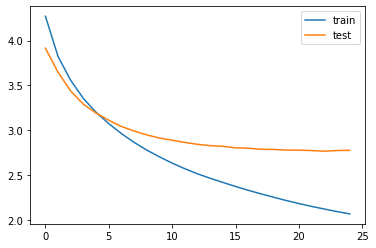

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [52]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [53]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [54]:
#어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
decoder_model.summary()
print('=3')

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1280000     input_2[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # output이 왜
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp

print('=3')

=3


In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : banned australian cricketer cameron bancroft executed ball tampering plan south africa said giving spot team free breaks heart panicked situation sorry feel like let everyone added going really long road earn respect back said 
실제 요약 : sostoken giving up spot in team for free breaks my heart 
예측 요약 :  australian captain calls for australian tour


원문 : australia accused new zealand opposition conspiring bring government accused new zealand labour party raising question australian deputy prime minister joyce dual citizenship parliament proven true joyce would disqualified australian government would lose one seat majority lower house 
실제 요약 : sostoken australia accuses nz opp of trying to government 
예측 요약 :  aus mp to probe into corruption charges


원문 : south africa ab de villiers scored test runs far said reaching run landmark means absolutely zero care speaking approach towards batting ab de villiers said feel something comes naturally 
실제 요약 : sostoken test runs mean absolutel

예측 요약 :  will join politics if he is not join politics kapil


원문 : women allowed uttar pradesh rishi ashram people believe saint gets angry seeing women leading drought like conditions region assam prohibits women entering preserve purity citing menstruation reason karnataka lord temple women children owing temple legend 
실제 요약 : sostoken which indian religious places do not allow women to enter 
예측 요약 :  women women not in open to women in women in up


원문 : delhi reported maximum number seizures fake indian currency notes lakh notes worth crore recovered data revealed thursday annual report national crime records bureau total number lakh fake notes worth nearly crore seized report added 
실제 요약 : sostoken delhi reported maximum number of of fake notes 
예측 요약 :  people worth cr from fake notes in delhi


원문 : online fashion store trolled bag supposed say favourite colour seems say favourite colour hitler due font colour also hitler commented user favourite colour appears hitler poor c

예측 요약 :  release date of saif ali khan announced


원문 : pakistan tehreek insaf party expected formally announce party chief imran khan pm candidate monday reports said party year old cricketer turned politician emerged single largest side national assembly recent general elections khan expected announce member federal cabinet first phase government formation 
실제 요약 : sostoken pti to announce imran khan as pakistan pm candidate tomorrow 
예측 요약 :  pak pm imran khan candidate party to be auctioned for polls


원문 : pakistan occupied kashmir pm raja farooq haider khan sunday said civilian helicopter violated indian airspace along line control fired upon indian army indian army fired show pakistan violated airspace khan office said adding chopper within airspace firing took place 
실제 요약 : sostoken pok pm says indian army shot at his chopper that violated airspace 
예측 요약 :  pak pm calls with indian drone in jammu and kashmir


원문 : bjp mlas rajasthan thursday chanted jai shri ram house celebr

In [84]:
import requests
from summa.summarizer import summarize

In [85]:
textforsum = np.array(data['text'])

In [86]:
textforsum[1]

'oneplus emerged india best selling premium smartphone brand per report counterpoint captured market share premium segment oneplus emerged highest selling premium smartphone followed oneplus'

In [88]:
print('Summary:')
text = 'rahul dravid asked decision taken role ms dhoni yuvraj singh indian team want look available talent see offer going back players asked dravid said decision india taken '
print(summarize(text))

Summary:



In [101]:
print(len(text0))

168


In [115]:
type(text0)

str

In [117]:
text0 = 'Sure! Here’s a short paragraph for you:In the heart of the city, the sun dipped below the horizon, painting the sky in shades of orange and pink. People strolled through the bustling streets, laughter and chatter filling the air. A gentle breeze carried the scent of freshly baked bread from a nearby café. As night fell, the city lights twinkled like stars, creating a magical atmosphere.'
print(len(text0))
print(summarize(text0, split=True))

389
['Here’s a short paragraph for you:In the heart of the city, the sun dipped below the horizon, painting the sky in shades of orange and pink.']


In [92]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [95]:
print(len(text))

35932


In [94]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
